refer from https://arxiv.org/abs/1607.04381

In [11]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [12]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


['/device:CPU:0']


In [13]:
# import necessary libraries
import matplotlib
%matplotlib inline

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

plt.ion()

from random import randint
import time

from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import keras
from   keras.datasets   import mnist

from   tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

eps = 1e-10


In [14]:
# data load
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to 1 dim
X_train      = X_train.reshape(np.shape(X_train)[0], 
                               (np.shape(X_train)[1] * np.shape(X_train)[2]))
X_test       = X_test.reshape(np.shape(X_test)[0], 
                              (np.shape(X_test)[1] * np.shape(X_test)[2]))

# change type
X_train      = X_train.astype('float32')
X_test       = X_test.astype('float32')

# normalization
X_train_mean = np.mean(X_train)
X_train_std  = np.std(X_train)
X_train      = (X_train - X_train_mean) / (X_train_std + eps)
X_test       = (X_test  - X_train_mean) / (X_train_std + eps)

# convert class vectors to binary class matrices
class_num    = np.max(y_train) + 1 # consider class 0 
y_train      = keras.utils.to_categorical(y_train, class_num).astype('float32')
y_test       = keras.utils.to_categorical(y_test,  class_num).astype('float32')

print('np.shape(X_train) = (%d, %d)' % np.shape(X_train))
print('np.shape(y_train) = (%d, %d)' % np.shape(y_train))
print('np.shape(X_test)  = (%d, %d)' % np.shape(X_test))
print('np.shape(y_test)  = (%d, %d)' % np.shape(y_test))


np.shape(X_train) = (60000, 784)
np.shape(y_train) = (60000, 10)
np.shape(X_test)  = (10000, 784)
np.shape(y_test)  = (10000, 10)


In [15]:
# set parameter for training
initial_learning_rate = 2.0
decay_learning_rate   = 0.999
epoch_num             = 50
mini_batch_size       = (128 * 4)
mini_batch_iter       = 30 # if None then all train data use　on a epoch
random_seed           = 0
dropconnect_ratio     = 0.7
drop_timing           = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [16]:
# fix mini batch iteration num
train_data_num      = len(y_train)
mini_batch_iter_tmp = round((train_data_num / mini_batch_size) - 0.5)
if (mini_batch_iter is None):
    mini_batch_iter = mini_batch_iter_tmp
else:
    if (mini_batch_iter > mini_batch_iter_tmp):
        mini_batch_iter = mini_batch_iter_tmp
        print('mini_batch_iter is too huge...')
        print('suppress to mini_batch_iter = %d' % mini_batch_iter)
        print('')

print('mini_batch_iter = %d' % mini_batch_iter)


mini_batch_iter = 30


In [17]:
np.random.seed(random_seed)

sess            = tf.InteractiveSession()

# make model by tensorflow

# input layer
x               = tf.placeholder(dtype=tf.float32, shape=[None, 784])

# multiply weight
weight_1        = tf.Variable(initial_value=tf.random_normal(shape=[784, 100], 
                                                             mean=0.0, stddev=0.01))
bias_1          = tf.Variable(initial_value=tf.zeros([100]))

# drop connect
weight_mask_1   = tf.Variable(initial_value=tf.zeros([784, 100]), trainable=False)
droped_weight_1 = weight_1 * weight_mask_1

# 
matmul_1        = tf.matmul(a=x, b=droped_weight_1) + bias_1

# activation
activated_1     = tf.nn.relu(features=matmul_1)

# multiply weight
weight_2        = tf.Variable(initial_value=tf.random_normal(shape=[100, 10], 
                                                             mean=0.0, stddev=0.01))
bias_2          = tf.Variable(initial_value=tf.zeros([10]))

# 
matmul_2        = tf.matmul(a=activated_1, b=weight_2) + bias_2

# output layer
y               = tf.nn.softmax(logits=matmul_2)


/anaconda3/envs/develop_36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
# define loss function and optimizer
y_            = tf.placeholder(dtype=tf.float32, shape=[None, 10])
prediction    = tf.clip_by_value(t=y, clip_value_min=eps, clip_value_max=1.0)
loss          = - tf.reduce_mean( input_tensor=(y_ * tf.log(prediction)) )

global_step   = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=initial_learning_rate,
                                           global_step=global_step,
                                           decay_steps=mini_batch_iter,
                                           decay_rate=decay_learning_rate)

optimizer     = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step    = optimizer.minimize(loss=loss)

tf.global_variables_initializer().run()


KeyboardInterrupt: 

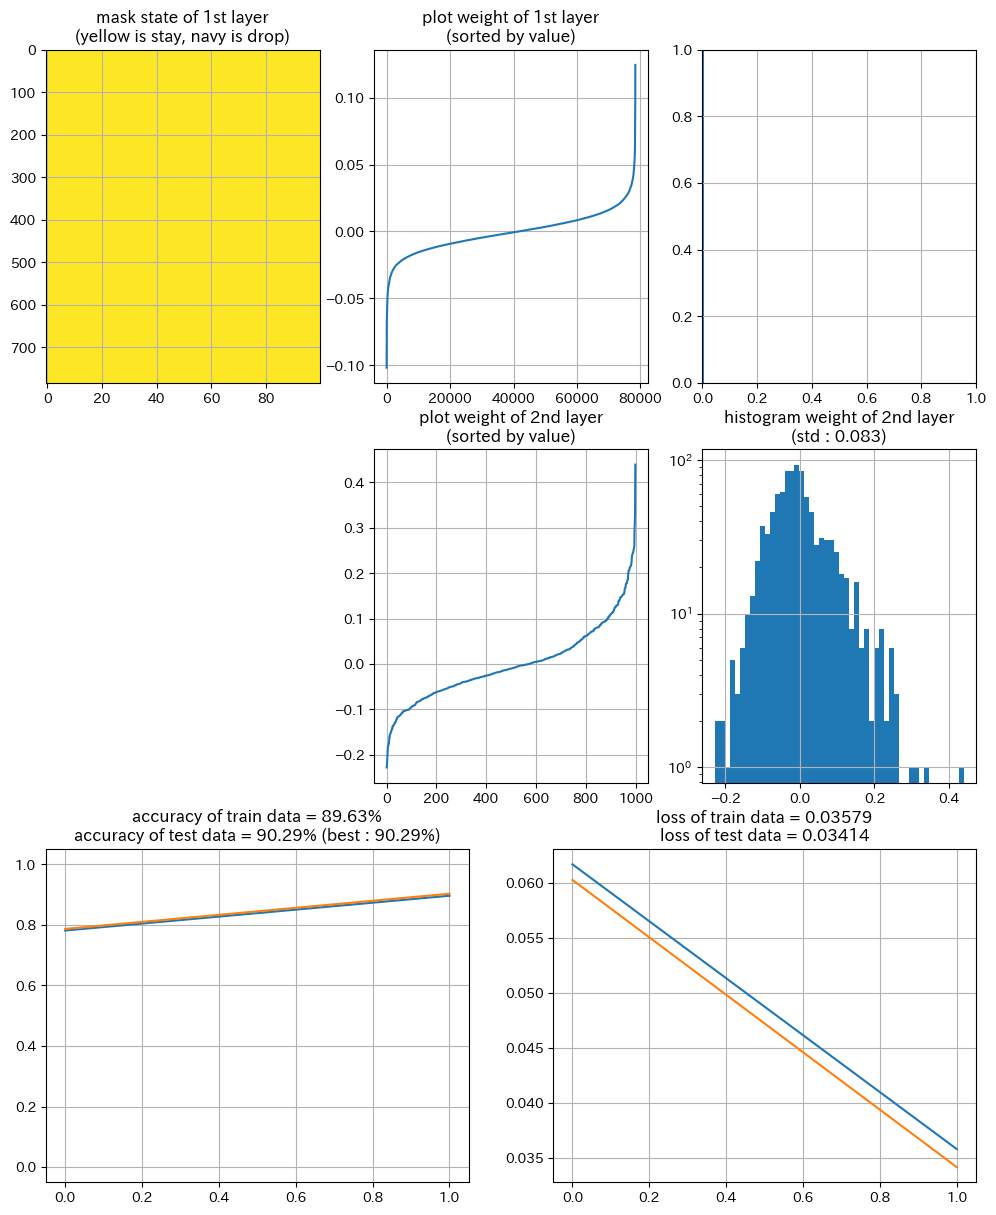

In [19]:
# 
train_acc_stock  = np.zeros(epoch_num)
test_acc_stock   = np.zeros(epoch_num)
test_acc_best    = 0.0
train_loss_stock = np.zeros(epoch_num)
test_loss_stock  = np.zeros(epoch_num)

fig              = plt.figure(figsize=(12,15),dpi=100)
draw_pitch       = 2

# training
for epoch_i in range(epoch_num):
    
    # drop connect (like dropout)
    weight_tmp  = sess.run(weight_1)
    if ( drop_timing[(epoch_i % len(drop_timing))] == 1 ):
        weight_tmp              = sess.run(weight_1)
        # weight_feature_abs      = np.sum(np.abs(weight_tmp), axis=1)
        weight_feature_abs      = np.sum((weight_tmp ** 2), axis=1)
        weight_feature_abs_sort = np.sort(np.abs(weight_feature_abs))
        weight_threshold        = weight_feature_abs_sort[round(len(weight_feature_abs_sort) * dropconnect_ratio)]
        weight_mask             = (weight_feature_abs > weight_threshold).astype('float32')[:, np.newaxis]
        weight_mask             = np.matlib.repmat(weight_mask, 1, np.shape(weight_tmp)[1])
    else:
        weight_mask             = np.ones(np.shape(weight_tmp), dtype='float32')
    weight_1.load(weight_tmp * weight_mask, sess)
    weight_mask_1.load(weight_mask, sess)

    # make index for mini batch selection
    rand_idx    = np.random.permutation(len(y_train))
    
    # mini batch iteration (attentive　SGD)
    for iter_i in range(mini_batch_iter):
        
        # set mini batch data
        X_train_mini_batch   = X_train[rand_idx[:mini_batch_size], :]
        y_train_mini_batch   = y_train[rand_idx[:mini_batch_size], :]
        rand_idx             = rand_idx[mini_batch_size:]
        
        # learning
        train_step.run({x: X_train_mini_batch, y_: y_train_mini_batch})
        
    # validaiton
    correct_prediction        = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    calc_acc                  = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    train_acc_stock[epoch_i]  = calc_acc.eval(feed_dict={x: X_train, y_: y_train})
    test_acc_stock[epoch_i]   = calc_acc.eval(feed_dict={x: X_test,  y_: y_test})
    train_loss_stock[epoch_i] = sess.run(fetches=loss, feed_dict={x: X_train, y_: y_train})
    test_loss_stock[epoch_i]  = sess.run(fetches=loss, feed_dict={x: X_test,  y_: y_test})
    
    # best record update
    if (test_acc_best < test_acc_stock[epoch_i]):
        test_acc_best = test_acc_stock[epoch_i]
    
    if (((epoch_i + 1) % draw_pitch) == 0):
        
        # get now state
        weight_1_tmp      = sess.run(weight_1)
        weight_1_tmp      = np.sort(weight_1_tmp.flat[:])
        weight_mask_1_tmp = sess.run(weight_mask_1)
        weight_2_tmp      = sess.run(weight_2)
        weight_2_tmp      = np.sort(weight_2_tmp.flat[:])
    
        # draw
        ax_331 = fig.add_subplot(3, 3, 1)
        ax_331.cla()
        clear_output(wait=True)
        ax_331.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_331.imshow(weight_mask_1_tmp, vmin=0, vmax=1, aspect='auto')
        # plt.colorbar()
        plt.title('mask state of 1st layer\n(yellow is stay, navy is drop)')
        display(fig)

        ax_332 = fig.add_subplot(3, 3, 2)
        ax_332.cla()
        clear_output(wait=True)
        ax_332.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_332.plot(weight_1_tmp)
        plt.title('plot weight of 1st layer\n(sorted by value)')
        display(fig)

        ax_333 = fig.add_subplot(3, 3, 3)
        ax_333.cla()
        clear_output(wait=True)
        ax_333.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_333.hist(weight_1_tmp, bins=50)
        plt.yscale('log')
        plt.title('histogram weight of 1st layer\n(std : %.3f)' % np.std(weight_1_tmp))
        display(fig)

        ax_335 = fig.add_subplot(3, 3, 5)
        ax_335.cla()
        clear_output(wait=True)
        ax_335.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_335.plot(weight_2_tmp)
        plt.title('plot weight of 2nd layer\n(sorted by value)')
        display(fig)

        ax_336 = fig.add_subplot(3, 3, 6)
        ax_336.cla()
        clear_output(wait=True)
        ax_336.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_336.hist(weight_2_tmp, bins=50)
        plt.yscale('log')
        plt.title('histogram weight of 2nd layer\n(std : %.3f)' % np.std(weight_2_tmp))
        display(fig)

        ax_325 = fig.add_subplot(3, 2, 5)
        ax_325.cla()
        clear_output(wait=True)
        ax_325.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_325.plot(train_acc_stock[:(epoch_i + 1)])
        ax_325.plot(test_acc_stock[:(epoch_i + 1)])
        plt.ylim(-0.05, 1.05)
        plt.title('accuracy of train data = %.2f%%\naccuracy of test data = %.2f%% (best : %.2f%%)' % ((train_acc_stock[epoch_i] * 100), (test_acc_stock[epoch_i] * 100), (test_acc_best * 100)))
        display(fig)

        ax_326 = fig.add_subplot(3, 2, 6)
        ax_326.cla()
        clear_output(wait=True)
        ax_326.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
        ax_326.plot(train_loss_stock[:(epoch_i + 1)])
        ax_326.plot(test_loss_stock[:(epoch_i + 1)])
        plt.title('loss of train data = %.5f\nloss of test data = %.5f' % (train_loss_stock[epoch_i], test_loss_stock[epoch_i]))
        display(fig)


In [20]:
weight_1

<tf.Variable 'Variable_6:0' shape=(784, 100) dtype=float32_ref>

In [21]:
type(weight_1)

tensorflow.python.ops.variables.Variable